# Analytical Anvil Lifecycle CRE Model example
Nick Lutsko (SIO/UCSD). Last updated: 11/12/2025

This is a short notebook illustrating how to use the functions for the CRE model and how they can be used to calculate high anvil CRE for a lifecycle in 3 steps:

**Step 1:** Define a typical anvil lifecycle (time, insolation, viewing geometry) + set parameters

**Step 2:** Use the analytic spreading, thinning, and CRE models to compute spreading rate, cloud radius, cloud optical depths and CREs

**Step 3:** Visualize the results

The following cells load modules and have the functions which make up the model. Skip down to "Example Usage" to see how to use the model.

In [1]:
#First load the modules we'll need
import numpy as np
import matplotlib.pylab as plt
import scipy.interpolate as si
%matplotlib inline

In [2]:
def spreading_rate_model(time, r0, b1, a, ur0, td, Delta):
    """
    The spreading rate model. Inputs:
    time = array of times [s]
    r0 = initial cloud radius [m]
    b1 = doubling time (b^-1) [s]
    a = inverse friction time-scale [s-1]
    ur0 = radiative spreading rate [m/s]
    td = decay onset [s]
    Delta = decay length [s]

    Outputs:
    u = cloud spreading rate [m/s]
    r = cloud radius [m]
    """   
    t = len(time)
    dt = time[1] - time[0]

    u = np.zeros(t)
    r = np.zeros(t)
    r[0] = r0
    u[0] = r0 ** 2 / (2. * b1 * r[0]) * np.exp(-a / 2. * time[0]) + ur0 / 2. * (1. + np.tanh( (td - time[0]) / Delta))
    
    for i in range( 1, t ):
        r[i] = r[i - 1] + dt * u[i - 1]
        u[i] = r0 ** 2 / (2. * b1 * r[i]) * np.exp(-a / 2. * time[i]) + ur0 / 2. * (1. + np.tanh( (td - time[i]) / Delta))

    return u, r

In [3]:
def cloud_thinning_model(time, kappa, u, r, tau_0, qvs, RH, rho = 0.3, 
                         h = 4000, rho_ice = 917., r_e = 30 * 10. ** -6.):
    """
    The cloud thinning model. Inputs:
    time = array of times [s]
    kappa = Kessler coefficient [s-1]
    u = spreading rate [m/s]
    r = cloud radius [m]
    tau_0 = initial cloud optical depth []
    qvs = environmental saturation mixing ratio [kg/kg]
    RH = environmental RH []
    rho = air density [kgm-3]
    h = cloud depth [m]
    rho_ice = ice density [kgm-3]
    r_e = effective radius [m]

    Outputs:
    tau = cloud optical depth
    """  
    
    t = len(time)
    dt = time[1] - time[0]
    tau = np.zeros(t)
    tau[0] = tau_0
    tau_1 = 3. / 2. * rho * h / rho_ice / r_e
    
    for i in range(1, t):
        qc = tau[i - 1] / tau_1
        tau[i] = tau[i - 1] - dt * (kappa + 2. * u[i - 1] / r[i - 1]) * tau[i - 1] - dt * 2. * u[i - 1] / r[i - 1] * (1. - RH) * qvs * tau_1
        if tau[i] < 0.: #just to be safe
            tau[i] = 0.
    return tau

In [4]:
#Now make CRE model, given \tau
def CRE_model(time, Qs, mu, interpolator, tau, tau_high, Tc0 = 225., lw_mu = 0.6, w = 0.12, 
              Gamma = 9.8/1000., cs_alb = 0.15, Te = 269., gamma = 1. / 2.3):
    """
    The cloud radiative effect model. Inputs:
    time = array of times [s]
    Qs = insolation [Wm-2]
    mu = cosine SW zenith angle
    interpolator = interpolation function to calculate \beta given mu
    tau = total cloud optical depth 
    tau_high = high cloud optical depth (for LW CRE)
    Tc0 = initial cloud temperature [K]
    lw_mu = cosine LW zenith angle
    w = sedimentation speed [m/s]
    Gamma = temperature lapse-rate [K/m]
    cs_alb = clear-sky albedo
    Te = environmental temperature [K}
    gamma = constant linking SW and LW optical depths


    Outputs:
    lw_cre = LW CRE [Wm-2]
    sw_cre = SW CRE [Wm-2]
    Tc = cloud temperature [K]
    """      
    t = len(time)
    dt = time[1] - time[0] # assume linear time spacing

    sigma = 5.67e-8               # Stefan-Boltzmann constant [W m^-2 K^-4]

    #cloud temperature -- linear increase as cloud sinks
    Tc = Tc0 + Gamma * w * (time - time[0])
    Tc = np.minimum(Tc, Te)

    #LW CRE from the emissivity
    emiss = (1. - np.exp(-gamma*tau_high/lw_mu))
    emiss[emiss<0.] = 0. #just to make sure
    lw_cre = emiss * sigma * (Tc ** 4 - Te ** 4)

    #Now SW CRE
    # Handle mu as scalar or time-dependent array
    mu_arr = np.asarray(mu)
    if mu_arr.ndim == 0 or mu_arr.size == 1:
        mu_used = np.full_like(tau, float(mu_arr))
    else:
        mu_used = mu_arr  # assume same length as time

    #Calculate albedos using total cloud optical depth
    # beta(mu): scalar or array
    beta_vals = interpolator(mu_arr)
    if np.ndim(beta_vals) == 0 or np.size(beta_vals) == 1:
        beta = np.full_like(tau, float(beta_vals))
    else:
        beta = beta_vals  # assume same length as time

    #Two-stream-like SW albedo: α = β τ / (μ + β τ)
    albedo = beta * tau / (mu_used + beta * tau)  
    #Calculate SW CRE
    albedo[albedo < cs_alb] = cs_alb
    
    sw_cre = Qs * (albedo - cs_alb)
    sw_cre[sw_cre < 0.] = 0.
    
    return lw_cre, sw_cre, Tc

### Example Usage

In [5]:
#Step 1: Set-up

#Lifecycle, insolation and zenith angles
time = np.linspace(0., 12 * 60. * 60., 2000) #time array
#assume convection starts at sunrise
Qs = 1300. * np.sin(np.pi * time / 60. / 60. / 12.)
Qs[Qs < 0.] = 0.
theta = -np.pi / 2. + time / 60. / 60.  * np.pi / 12.
mu = np.cos(theta)
mu[mu < 0.001] = 0.001 #avoid zeros

#spreading rate parameters:
r0 = 20000.
b1 = 15. * 60.
a = 1. / (30. * 60.)
ur0 = 2.
td = 8. * 60. * 60.
Delta = 60. * 60.

#microphysics parameters:
kappa = 1. / (5. * 60. * 60.)
tau0 = 300.
qvs = 10. ** -4.
RH = 0.4

#radiation parameters:
Tc = 225.
w = 0.12

In [6]:
#load data and create interpolator for \beta
data = np.load("data/interpolator_data.npz")
mu_d = data["mu"]
beta_d = data["beta2"]

interpolator = si.interp1d(mu_d, beta_d)

In [7]:
#Step 2: run the model

u, r = spreading_rate_model(time, r0, b1, a, ur0, td, Delta)
tau = cloud_thinning_model(time, kappa, u, r, tau0, qvs, RH) #high cloud optical depth
tau_tot = tau + 1.6 #total cloud optical depth
lw_cre, sw_cre, Tc = CRE_model(time, Qs, mu, interpolator, tau_tot, tau)

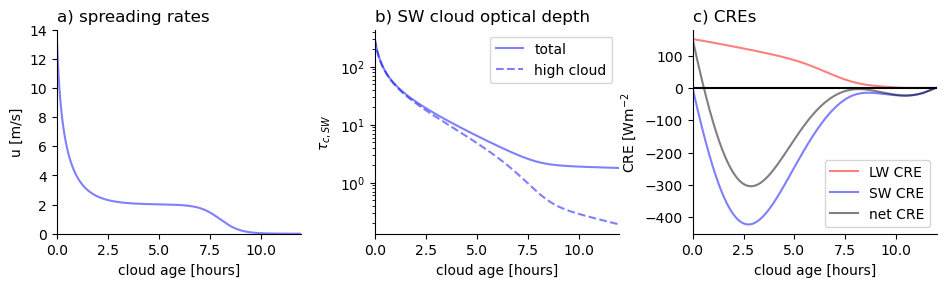

In [8]:
#Step 3: Plot

fig = plt.figure(figsize = (10, 3))
plt.subplots_adjust(left = 0.07, right = 0.95, wspace = 0.3, bottom = 0.2)

ax = plt.subplot(1, 3, 1)
plt.title("a) spreading rates", loc = "left")
plt.plot(time / 60. / 60., u, 'b', alpha = 0.5)

plt.xlim([0., 12.])
plt.ylim([0., 14.])

ax.spines[['right', 'top']].set_visible(False)

plt.ylabel("u [m/s]")
plt.xlabel("cloud age [hours]")

ax = plt.subplot(1, 3, 2)
plt.title("b) SW cloud optical depth", loc = "left")
plt.semilogy(time / 60. / 60., tau_tot, 'b', alpha = 0.5)
plt.semilogy(time / 60. / 60., tau, 'b--', alpha = 0.5)

plt.xlim([0., 12.])

ax.spines[['right', 'top']].set_visible(False)

plt.ylabel("$\\tau_{c,SW}$")
plt.xlabel("cloud age [hours]")
plt.legend(["total", "high cloud"])

ax = plt.subplot(1, 3, 3)
plt.title("c) CREs", loc = "left")
plt.plot(time / 60. / 60., -lw_cre, 'r', alpha = 0.5)
plt.plot(time / 60. / 60., -sw_cre, 'b', alpha = 0.5)
plt.plot(time / 60. / 60., -lw_cre - sw_cre, 'k', alpha = 0.5)

plt.xlim([0., 12.])

ax.spines[['right', 'top']].set_visible(False)

plt.ylabel("CRE [Wm$^{-2}$")
plt.xlabel("cloud age [hours]")

plt.legend(["LW CRE", "SW CRE", "net CRE"])
plt.axhline(y = 0., color = 'k')
